In [1]:
import pandas as pd

In [3]:
df_team_stats = pd.read_csv('C:\\Users\\bhavi\\Downloads\\Downloads\\Project\\Data\\team_stats.csv')

df_team_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Team            48 non-null     object 
 1   Season          48 non-null     int64  
 2   Gender          48 non-null     object 
 3   Avg Score       48 non-null     float64
 4   Avg Economy     48 non-null     float64
 5   Win %           48 non-null     float64
 6   Win Count       48 non-null     int64  
 7   Matches Played  48 non-null     int64  
dtypes: float64(3), int64(3), object(2)
memory usage: 3.1+ KB


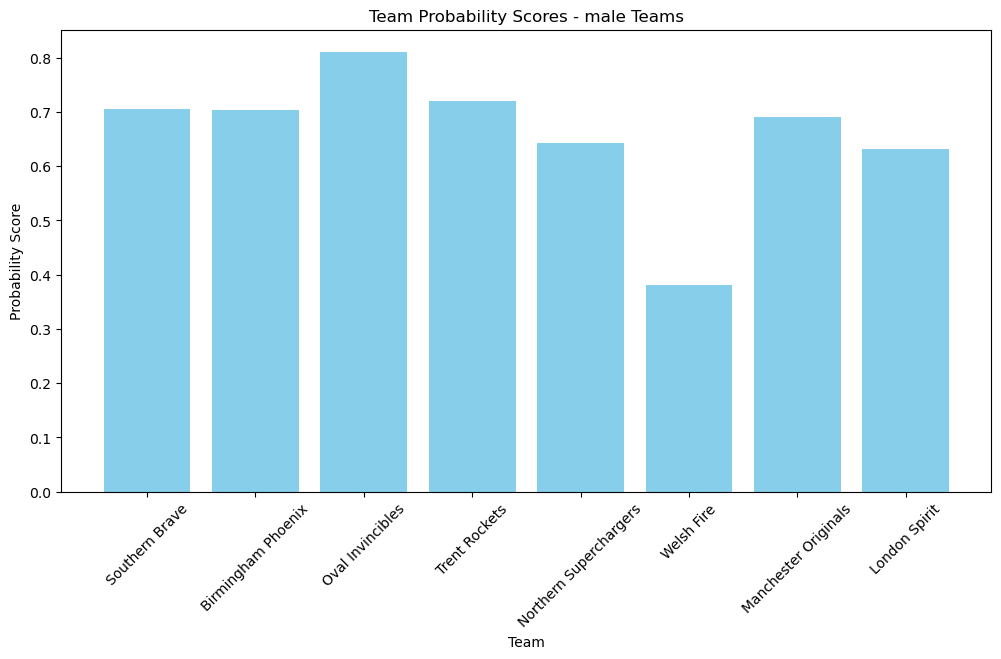

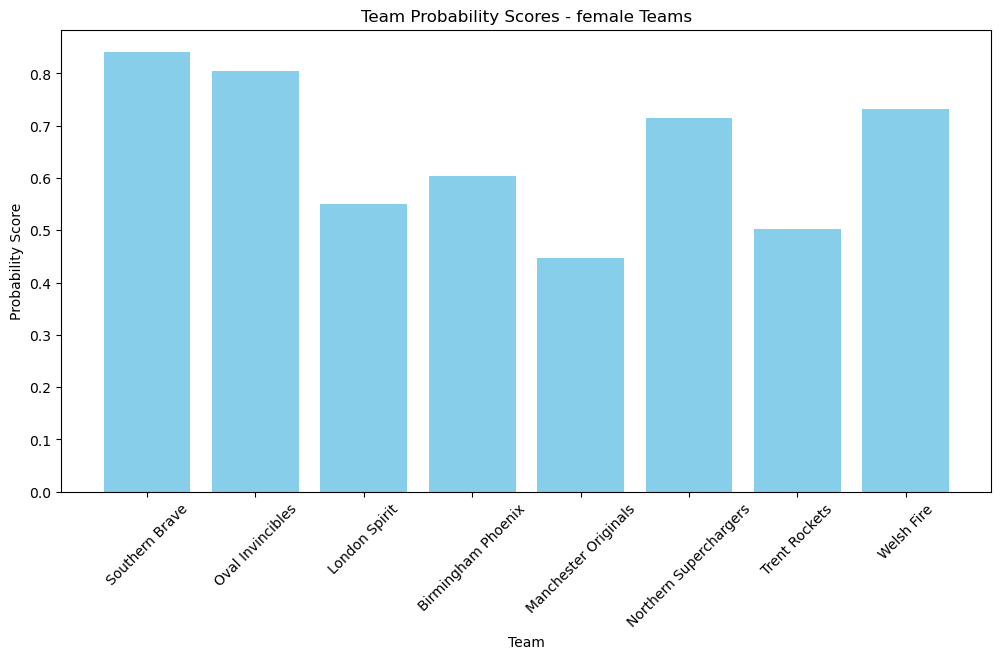

In [6]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt


# Define benchmarks for team stats
benchmarks = {
    'male': {'avg_score': 150, 'avg_economy': 7.5, 'win_percentage': 50},
    'female': {'avg_score': 130, 'avg_economy': 6.5, 'win_percentage': 50}
}

# Calculate residuals for teams
def calculate_team_residuals(data, benchmarks):
    data['score_residual'] = data.apply(lambda row: 
                                        row['Avg Score'] - benchmarks[row['Gender']]['avg_score'], axis=1)
    data['economy_residual'] = data.apply(lambda row: 
                                          benchmarks[row['Gender']]['avg_economy'] - row['Avg Economy'], axis=1)
    data['win_percentage_residual'] = data.apply(lambda row: 
                                                 row['Win %'] - benchmarks[row['Gender']]['win_percentage'], axis=1)
    return data

df_team_stats = calculate_team_residuals(df_team_stats, benchmarks)

# Calculate probability scores for teams
def calculate_team_probability_scores(data):
    # Standardize residuals
    mean_score_residual = data['score_residual'].mean()
    std_score_residual = data['score_residual'].std()
    data['score_prob_score'] = norm.cdf((data['score_residual'] - mean_score_residual) / std_score_residual)
    
    mean_economy_residual = data['economy_residual'].mean()
    std_economy_residual = data['economy_residual'].std()
    data['economy_prob_score'] = norm.cdf((data['economy_residual'] - mean_economy_residual) / std_economy_residual)
    
    mean_win_percentage_residual = data['win_percentage_residual'].mean()
    std_win_percentage_residual = data['win_percentage_residual'].std()
    data['win_percentage_prob_score'] = norm.cdf((data['win_percentage_residual'] - mean_win_percentage_residual) / std_win_percentage_residual)
    
    # Combine probability scores into a single probability score
    data['team_prob_score'] = (data['score_prob_score'] + data['economy_prob_score'] + data['win_percentage_prob_score']) / 3
    
    return data

df_team_stats = calculate_team_probability_scores(df_team_stats)

# Visualize team stats probability scores
def plot_team_probability_scores(data, gender):
    plt.figure(figsize=(12, 6))
    plt.bar(data['Team'], data['team_prob_score'], color='skyblue')
    plt.xlabel('Team')
    plt.ylabel('Probability Score')
    plt.title(f'Team Probability Scores - {gender} Teams')
    plt.xticks(rotation=45)
    # plt.savefig(f'Team Probability Scores - {gender} Teams.png')
    plt.show()

male_team_stats = df_team_stats[df_team_stats['Gender'] == 'male']
female_team_stats = df_team_stats[df_team_stats['Gender'] == 'female']

plot_team_probability_scores(male_team_stats, 'male')
plot_team_probability_scores(female_team_stats, 'female')


#male_team_stats.to_csv('processed_male_team_data.csv', index=False)
#female_team_stats.to_csv('processed_female_team_data.csv', index=False)


In [ ]:
# Combine male and female player data into single dataframes
combined_batsman_data = pd.concat([male_batsman_data, female_batsman_data])
combined_bowler_data = pd.concat([male_bowler_data, female_bowler_data])

p_df = df

# Combine male and female data
combined_batsman_data = pd.concat([male_batsman_data, female_batsman_data], ignore_index=True)
combined_bowler_data = pd.concat([male_bowler_data, female_bowler_data], ignore_index=True)

p_df = p_df.merge(combined_batsman_data, on = ['Player Name','Gender'] , how = 'left')
p_df = p_df.merge(combined_bowler_data, on = ['Player Name','Gender'] , how = 'left')
combined_team_stats = pd.concat([male_team_stats, female_team_stats], ignore_index = True)
combined_team_stats = combined_team_stats.rename(columns={'Team':'Player Team'})

p_df = p_df.merge(combined_team_stats, on = ['Player Team', 'Gender', 'Season'], how = 'left')

p_df = p_df.rename(columns = {'probability_score_x':'batsman_prob_score', 'probability_score_y':'bowler_prob_score'})

# Display basic information about the dataframe
print(p_df.info())

# Display the first few rows of the dataframe
print(p_df.head())
p_df = p_df.iloc[:,1:]
p_df = p_df.rename(columns = {'Win %': 'Player Team Win %', 'Win Count':'Player Team Win Count', 'Matches Played':'Team Matches Played', 
                      'Avg Score': 'Team Avg Score', 'Avg Economy': 'Team Avg Economy', 'total_runs': 'Player Total Runs',
                       'total_average_x':'Player Total Batting Average','aggregated_strike_rate':'Player Strike Rate', 
                       'batsman_prob_score':'Batsman Prob Score', 'bowler_prob_score':'Bowler Prob Score', 'total_balls_bowled':'Player Total Balls Bowled',
                       'total_runs_conceded':'Bowler Total Runs Conceded', 'total_wickets':'Bowler Total Wickets', 'total_average_y':'Player Bowling Average',
                        'score_prob_score':'Team Scoring Prob Score' , 'economy_prob_score':'Team Economy Prob Score', 'win_percentage_prob_score':'Team Winning % Prob in Season',
                        'team_prob_score':'Player Team Probability Score','aggregated_economy':'Bowler Aggregated Economy'})

p_df = p_df.drop(['residual_x','residual_y', 'score_residual','economy_residual','win_percentage_residual',
           'standardized_residual_y','standardized_residual_x','inning','match_id','gender','season'], axis = 1)


# Check for missing values
missing_values = p_df.isnull().sum()
print("Missing values in each column:\n", missing_values[missing_values > 0])

p_df = p_df[~p_df['Match Winner'].isin(['tie','no result'])]
# p_df.to_csv('C:\\Users\\bhavi\\Downloads\\Downloads\\Project\\Data\\Updated_p_df.csv')

